In [110]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np
import importlib


In [111]:
from data import Dataloader
from models import RandomExampleModel, TwoClustersMIP
import metrics

In [112]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [113]:
P, n = X.shape
K = 2
L = 10

In [128]:
len([(j, k) for j in range(2000) for k in range(2)])

4000

In [107]:
# P2 = 1000
# X,Y = X[:P2,:], Y[:P2,:]

In [114]:
importlib.reload(importlib.import_module('models'))
from models import RandomExampleModel, TwoClustersMIP

In [115]:
# Let's train an example model
model = TwoClustersMIP(n_pieces=L,n_clusters=K,n_criterions=n,n_pairs=P) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

Set parameter Seed to value 123
Fitting the model
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Manjaro Linux")

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6084 rows, 8088 columns and 69634 nonzeros
Model fingerprint: 0xe1f3f469
Variable types: 4088 continuous, 4000 integer (4000 binary)
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 2e+00]
Found heuristic solution: objective 107.4285603
Presolve removed 2010 rows and 2008 columns
Presolve time: 0.09s
Presolved: 4074 rows, 6080 columns, 62232 nonzeros
Variable types: 4080 continuous, 2000 integer (2000 binary)

Root relaxation: objective 0.000000e+00, 1270 iterations, 0.08 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

In [116]:
print(model.predict_utility(X))

[[0.973511   0.97683503]
 [0.84143614 0.610425  ]
 [0.79983178 0.48271099]
 ...
 [0.75440459 0.99371291]
 [0.75185742 0.98267199]
 [0.68414126 0.9828784 ]]


In [117]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 0.15147149 -0.01389374]
 [ 0.0950977  -0.38183603]
 [ 0.08881266 -0.49915283]
 [-0.04444407  0.25828882]
 [ 0.07673449 -0.00146251]]


In [118]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [119]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [120]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.989
Percentage of explained preferences for all samples: 0.989


In [121]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [122]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [123]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.983136068034017
Cluster intersection for all samples: 0.983136068034017


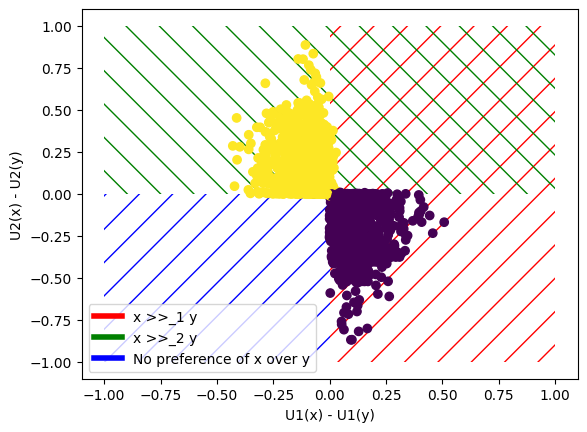

In [125]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z[:P])

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [16]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5, "n_clusters": 2} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)

# Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

fitting


KeyError: (5, 0)

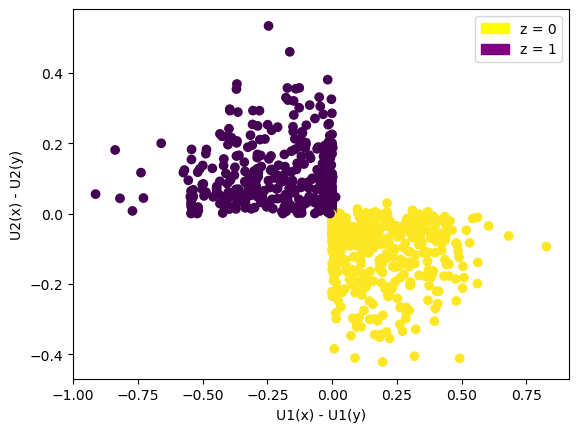

In [76]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find a model that will work well with larger data instances.